In [1]:
from fastai.collab import *
from fastai.basics import *

# on movie lens sample data

In [10]:
URLs.ML_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/movie_lens_sample.tgz'

In [12]:
path = untar_data(URLs.ML_SAMPLE)
path.ls()

(#1) [Path('/root/.fastai/data/movie_lens_sample/ratings.csv')]

In [19]:
train_df=pd.read_csv(path/'ratings.csv').drop('timestamp',axis=1)
print(len(train_df),"examples")
train_df.head()

6031 examples


,userId,movieId,rating
0,73,1097,4.0
1,561,924,3.5
2,157,260,3.5
3,358,1210,5.0
4,130,316,2.0


In [20]:
train_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [21]:
dls = CollabDataLoaders.from_df(train_df,user_name='userId',item_name='movieId',rating_name='rating',seed=3465)
dls.show_batch()

,userId,movieId,rating
0,262,597,2.0
1,431,3578,4.5
2,134,1197,4.0
3,452,1206,3.0
4,561,1073,4.0
5,355,3578,4.0
6,285,50,5.0
7,580,1097,4.0
8,195,1210,5.0
9,430,1036,4.0


In [28]:
learn = collab_learner(dls,n_factors=50,y_range=(0,5.5))

In [29]:
learn.fit_one_cycle(4,5e-3)

epoch,train_loss,valid_loss,time
0,1.688958,1.000352,00:00
1,0.876609,0.688908,00:00
2,0.654464,0.674108,00:00
3,0.565057,0.670958,00:00


# on movie lens 100k data

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip >&NULL
!rm NULL

--2022-08-02 09:26:10--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.9MB/s    in 0.3s    

2022-08-02 09:26:10 (16.9 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [3]:
path=Path('/content/ml-100k')
ratings = pd.read_csv(path/"u.data",delimiter='\t',header=None,names=['userId','movieId','rating','timestamp']).drop('timestamp',axis=1)
print(len(ratings),"examples")
ratings.head()

100000 examples


,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
movies=pd.read_csv(path/"u.item",delimiter='|',encoding='latin-1',header=None,
                   names=['movieId','title','date','N','url',*[f'g{i}' for i in range(19)]])
print('Number of movies:',len(movies))
movies.head()

Number of movies: 1682


,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
rating_movie=ratings.merge(movies[['movieId','title']])
rating_movie.head()

,userId,movieId,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [6]:
rating_movie.isna().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

In [7]:
dls = CollabDataLoaders.from_df(rating_movie,user_name='userId',item_name='title',rating_name='rating',seed=3465,valid_pct=0.1)
dls.show_batch()

,userId,title,rating
0,457,Wolf (1994),3
1,246,"Lost World: Jurassic Park, The (1997)",1
2,13,D3: The Mighty Ducks (1996),1
3,763,"Fugitive, The (1993)",5
4,243,Phenomenon (1996),3
5,425,"Ice Storm, The (1997)",3
6,936,"Craft, The (1996)",3
7,394,Apollo 13 (1995),4
8,265,Return of the Jedi (1983),2
9,27,Heaven's Prisoners (1996),2


In [8]:
learn = collab_learner(dls,n_factors=50,y_range=(0,5.5),wd=0.1)

SuggestedLRs(valley=0.013182567432522774)

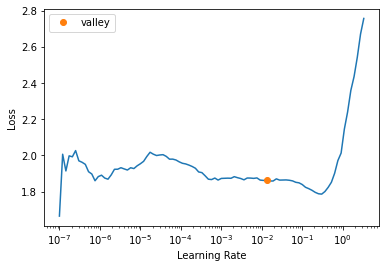

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,time
0,1.720693,1.671161,00:12
1,0.936519,0.957725,00:09
2,0.838571,0.875028,00:08
3,0.814717,0.847558,00:08
4,0.785386,0.833508,00:08
5,0.752776,0.824598,00:08
6,0.725473,0.818411,00:09
7,0.679988,0.815289,00:08
8,0.708362,0.814274,00:08
9,0.710666,0.814100,00:08


In [11]:
learn.save('movie_recommender')

Path('models/movie_recommender.pth')

# Interpretation

In [15]:
learn.load('/content/models/movie_recommender')

In [16]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [22]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

## movie bias

In [30]:
movie_bias = learn.bias(top_movies,is_item=True)
movie_bias.shape

torch.Size([1000])

In [37]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b,i,mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]
movie_ratings[:15]

[(tensor(0.3537), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.2535), 'Contact (1997)', 3.8035363457760316),
 (tensor(0.2210), 'Fargo (1996)', 4.155511811023622),
 (tensor(0.2484), 'Return of the Jedi (1983)', 4.007889546351085),
 (tensor(0.0726), 'Liar Liar (1997)', 3.156701030927835),
 (tensor(0.0637), 'English Patient, The (1996)', 3.656964656964657),
 (tensor(0.1633), 'Scream (1996)', 3.4414225941422596),
 (tensor(0.1865), 'Toy Story (1995)', 3.8783185840707963),
 (tensor(0.2094), 'Air Force One (1997)', 3.6310904872389793),
 (tensor(0.1037), 'Independence Day (ID4) (1996)', 3.438228438228438),
 (tensor(0.2507), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.2768), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.1960), 'Pulp Fiction (1994)', 4.060913705583756),
 (tensor(0.1707), 'Twelve Monkeys (1995)', 3.798469387755102),
 (tensor(0.3391), 'Silence of the Lambs, The (1991)', 4.28974358974359)]

In [38]:
sorted(movie_ratings,key=lambda x:x[0])[:15] # sorting in increasing order by movie bias value

[(tensor(-0.2866),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2081),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2026), 'Spice World (1997)', 2.1153846153846154),
 (tensor(-0.1852), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.1814), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.1811), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.1764), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.1720), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.1595), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.1588), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.1558), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.1554), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.1554), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.1487), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.1482

as we can see the movies with small bias have low average rating

In [39]:
sorted(movie_ratings,key=lambda x:x[0],reverse=True)[:15] # sorting in decreasing order by movie bias value

[(tensor(0.4043), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.3851), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.3811), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.3605), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.3560), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.3537), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.3529), 'Apt Pupil (1998)', 4.1),
 (tensor(0.3391), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.3344), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.3275), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.3119), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.3079), 'Full Monty, The (1997)', 3.926984126984127),
 (tensor(0.3052), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.3045), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.3010), 'Usual Suspects, The (1995)', 4.385767790262173)]

on the other hand movies with high bias have high average rating (they are liked by everyone)

## movie weights

In [41]:
movie_w = learn.weight(top_movies,is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [45]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [50]:
fac0,fac1,fac2=movie_pca.t()
movie_comp = [(f,i) for f,i in zip(fac0,top_movies)]
movie_comp[:4]

[(tensor(-0.8499), 'Star Wars (1977)'),
 (tensor(-0.1685), 'Contact (1997)'),
 (tensor(-0.9350), 'Fargo (1996)'),
 (tensor(-0.3715), 'Return of the Jedi (1983)')]

In [52]:
sorted(movie_comp,key=itemgetter(0),reverse=True)[:15]

[(tensor(1.4501), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.2855), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.2724), 'Jungle2Jungle (1997)'),
 (tensor(1.2191), "McHale's Navy (1997)"),
 (tensor(1.2150), 'Leave It to Beaver (1997)'),
 (tensor(1.1444), 'Home Alone 3 (1997)'),
 (tensor(1.1443), 'Bio-Dome (1996)'),
 (tensor(1.1433), 'Barb Wire (1996)'),
 (tensor(1.1016), 'Grease 2 (1982)'),
 (tensor(1.1001), 'Congo (1995)'),
 (tensor(1.0596), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0273), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(1.0210), 'Spice World (1997)'),
 (tensor(1.0127), 'Speed 2: Cruise Control (1997)'),
 (tensor(1.0126), 'Jaws 3-D (1983)')]

In [54]:
sorted(movie_comp,key=itemgetter(0))[:15]

[(tensor(-1.1774), 'Wrong Trousers, The (1993)'),
 (tensor(-1.1493), 'Casablanca (1942)'),
 (tensor(-1.0979), 'Godfather, The (1972)'),
 (tensor(-1.0934), 'Close Shave, A (1995)'),
 (tensor(-1.0725), "Schindler's List (1993)"),
 (tensor(-1.0348), 'Chinatown (1974)'),
 (tensor(-1.0338), 'Citizen Kane (1941)'),
 (tensor(-1.0264), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(-1.0246), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(-1.0118), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9825),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(-0.9694), 'Third Man, The (1949)'),
 (tensor(-0.9638), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9589), 'Rear Window (1954)'),
 (tensor(-0.9572), 'Shawshank Redemption, The (1994)')]

In [55]:
movie_comp = [(f,i) for f,i in zip(fac1,top_movies)]

In [56]:
sorted(movie_comp,key=itemgetter(0),reverse=True)[:15]

[(tensor(0.8304), 'Clockwork Orange, A (1971)'),
 (tensor(0.7923), 'Cable Guy, The (1996)'),
 (tensor(0.7794), 'Children of the Corn: The Gathering (1996)'),
 (tensor(0.7792), 'Serial Mom (1994)'),
 (tensor(0.7593), 'Big Night (1996)'),
 (tensor(0.7459), 'Brazil (1985)'),
 (tensor(0.7404), 'Stuart Saves His Family (1995)'),
 (tensor(0.7309), 'Jude (1996)'),
 (tensor(0.7299), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7002), 'Showgirls (1995)'),
 (tensor(0.6714), 'Very Brady Sequel, A (1996)'),
 (tensor(0.6695), 'Trainspotting (1996)'),
 (tensor(0.6644), 'Pallbearer, The (1996)'),
 (tensor(0.6556), 'Crumb (1994)'),
 (tensor(0.6517), 'Lost Highway (1997)')]

In [57]:
sorted(movie_comp,key=itemgetter(0))[:15]

[(tensor(-1.0714), 'Braveheart (1995)'),
 (tensor(-1.0415), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0243), 'Titanic (1997)'),
 (tensor(-1.0024), 'Independence Day (ID4) (1996)'),
 (tensor(-0.9510), 'Air Force One (1997)'),
 (tensor(-0.8287), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(-0.8269), 'Top Gun (1986)'),
 (tensor(-0.7943), 'Twister (1996)'),
 (tensor(-0.7894), 'Time to Kill, A (1996)'),
 (tensor(-0.7751), 'Back to the Future (1985)'),
 (tensor(-0.7733), 'Rock, The (1996)'),
 (tensor(-0.7684), 'While You Were Sleeping (1995)'),
 (tensor(-0.7603), 'American President, The (1995)'),
 (tensor(-0.7541), 'Pretty Woman (1990)'),
 (tensor(-0.7349), 'Hunt for Red October, The (1990)')]

In [58]:
movie_comp = [(f,i) for f,i in zip(fac2,top_movies)]

In [59]:
sorted(movie_comp,key=itemgetter(0),reverse=True)[:15]

[(tensor(0.6086), 'Chasing Amy (1997)'),
 (tensor(0.5969), 'Pulp Fiction (1994)'),
 (tensor(0.5930), 'Rock, The (1996)'),
 (tensor(0.5835), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.5746), 'Starship Troopers (1997)'),
 (tensor(0.5431), 'Terminator, The (1984)'),
 (tensor(0.5395), 'Scream (1996)'),
 (tensor(0.5209), "Devil's Advocate, The (1997)"),
 (tensor(0.4982), 'Heat (1995)'),
 (tensor(0.4891), 'Fifth Element, The (1997)'),
 (tensor(0.4872), 'Alien: Resurrection (1997)'),
 (tensor(0.4861), 'Spawn (1997)'),
 (tensor(0.4553), 'Mars Attacks! (1996)'),
 (tensor(0.4521), 'Terminator 2: Judgment Day (1991)'),
 (tensor(0.4382), "Dante's Peak (1997)")]

In [60]:
sorted(movie_comp,key=itemgetter(0))[:15]

[(tensor(-0.4732), 'Sound of Music, The (1965)'),
 (tensor(-0.4336), "It's a Wonderful Life (1946)"),
 (tensor(-0.4266), 'Ghost (1990)'),
 (tensor(-0.4216), 'To Kill a Mockingbird (1962)'),
 (tensor(-0.4187), 'Dirty Dancing (1987)'),
 (tensor(-0.4175), 'On Golden Pond (1981)'),
 (tensor(-0.4119), 'Sleepless in Seattle (1993)'),
 (tensor(-0.4076), 'Old Yeller (1957)'),
 (tensor(-0.3875), 'E.T. the Extra-Terrestrial (1982)'),
 (tensor(-0.3779), 'Star Trek V: The Final Frontier (1989)'),
 (tensor(-0.3679), 'Miracle on 34th Street (1994)'),
 (tensor(-0.3605), 'My Fair Lady (1964)'),
 (tensor(-0.3591), 'Field of Dreams (1989)'),
 (tensor(-0.3409), 'Piano, The (1993)'),
 (tensor(-0.3238), 'Steel (1997)')]

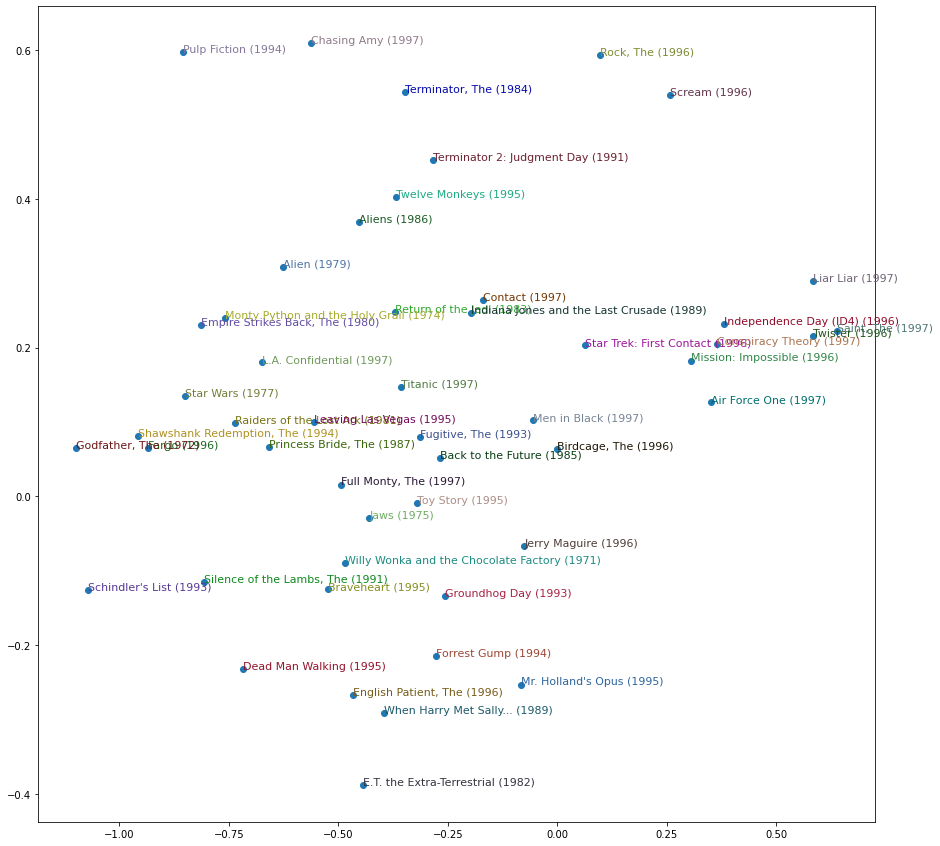

In [66]:
idxs=np.random.choice(len(top_movies),50,replace=False)
idxs=list(range(50))
X=fac0[idxs]
Y=fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)
for movie_name,x,y in zip(top_movies[idxs],X,Y):
  plt.text(x,y,movie_name,color=np.random.rand(3)*0.7,fontsize=11)
plt.show()

In [67]:
learn.export("movie_lens_recommendation_model")

In [69]:
new_learn=load_learner("movie_lens_recommendation_model")

In [70]:
new_learn.weight(top_movies,is_item=True)

tensor([[ 0.1239,  0.0972,  0.2932,  ..., -0.2573, -0.3343, -0.0676],
        [ 0.0354,  0.0892,  0.1594,  ..., -0.1110, -0.1378, -0.1189],
        [ 0.3199, -0.3862,  0.2226,  ...,  0.0038, -0.0813,  0.2009],
        ...,
        [ 0.0093,  0.0006, -0.0148,  ...,  0.0431,  0.0416,  0.0695],
        [-0.1296,  0.2175, -0.0675,  ..., -0.0122,  0.0587, -0.1430],
        [-0.0602, -0.1402,  0.0334,  ...,  0.0259,  0.0109,  0.0335]])

In [85]:
movie_names=np.array(movies['title']).astype(str)
np.savetxt("movie_names.npy",movie_names,fmt="%s",delimiter='')

In [87]:
np.loadtxt('movie_names.npy',delimiter='\n',dtype=str)

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype='<U81')

In [88]:
movie_names

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype='<U81')